<a href="https://colab.research.google.com/github/yyousharashid-lab/CVPR/blob/main/MID/assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For reproducible results
np.random.seed(0)


Dataset Generation:

In [ ]:
# Generate synthetic dataset (5 classes)
def generate_dataset(n=1500):
    """
    Generate a 2D toy dataset with 5 classes.
    Class assignment is done using simple threshold rules
    on (x1, x2) so that the decision boundaries are non-trivial.

    Parameters
    ----------
    n : int
        Number of samples.

    Returns
    -------
    X : (n, 2) float array
        Input features.
    y_int : (n,) int array
        Integer labels in {0, 1, 2, 3, 4}.
    """
    # Random 2D points
    X = np.random.randn(n, 2) * 2
    y_int = np.zeros((n,), dtype=int)

    # Simple geometric rules to define 5 classes
    # Class 1: upper-right region
    y_int[(X[:, 0] > 1) & (X[:, 1] > 0.5)] = 1
    # Class 2: upper-left region
    y_int[(X[:, 0] < -1) & (X[:, 1] > 0)] = 2
    # Class 3: lower-right region
    y_int[(X[:, 0] > 0) & (X[:, 1] < -1)] = 3
    # Class 4: lower-left region
    y_int[(X[:, 0] < 0) & (X[:, 1] < -0.5)] = 4

    return X, y_int

# Generate dataset
X, y_raw = generate_dataset(1500)

# One-hot encode labels for softmax + cross-entropy
num_classes = 5
Y = np.eye(num_classes)[y_raw]

print("X shape:", X.shape)
print("Y (one-hot) shape:", Y.shape)
print("Integer labels:", y_raw[:10])


X shape: (1500, 2)
Y (one-hot) shape: (1500, 5)
Integer labels: [1 1 3 0 0 0 0 0 0 3]


Train/Test Split

In [ ]:
# Shuffle dataset (same permutation for X, Y, y_raw)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]
y_raw = y_raw[indices]

# 75% training, 25% testing
split = int(0.75 * X.shape[0])

X_train = X[:split]
Y_train = Y[:split]

X_test  = X[split:]
Y_test  = Y[split:]

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


Train size: 1125
Test size : 375


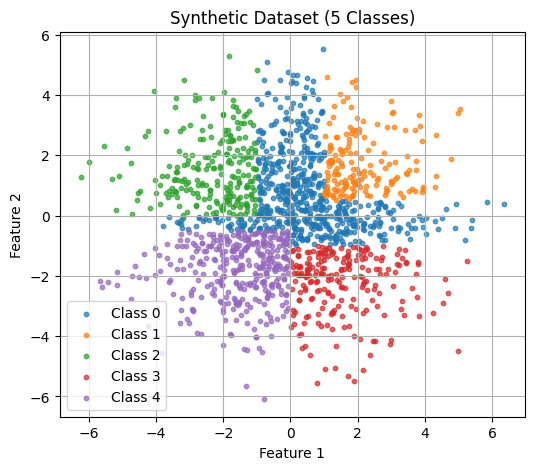

In [ ]:
# Visualize dataset in 2D
plt.figure(figsize=(6, 5))
for c in range(num_classes):
    plt.scatter(
        X[y_raw == c, 0], X[y_raw == c, 1],
        s=10, alpha=0.7, label=f"Class {c}"
    )
plt.title("Synthetic Dataset (5 Classes)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Neural Network Definition
class NeuralNetwork(object):
    def __init__(self):
        """
        3-hidden-layer fully-connected neural network for
        5-class classification.

        Architecture:
        2 (input) -> 10 -> 10 -> 10 -> 5 (output)
        """

        inputLayerNeurons = 2
        hiddenLayer1 = 10
        hiddenLayer2 = 10
        hiddenLayer3 = 10
        outputNeurons = 5

        self.learning_rate = 0.01

        # He initialization (good for ReLU)
        self.W_H1 = np.random.randn(inputLayerNeurons, hiddenLayer1) * np.sqrt(2.0 / inputLayerNeurons)
        self.W_H2 = np.random.randn(hiddenLayer1, hiddenLayer2) * np.sqrt(2.0 / hiddenLayer1)
        self.W_H3 = np.random.randn(hiddenLayer2, hiddenLayer3) * np.sqrt(2.0 / hiddenLayer2)
        self.W_O  = np.random.randn(hiddenLayer3, outputNeurons)  * np.sqrt(2.0 / hiddenLayer3)

    # Hidden activation: ReLU
    def relu(self, x, der=False):
        """
        ReLU(x) = max(0, x)
        d/dx ReLU(x) = 1 if x > 0 else 0
        """
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    # Output activation: Softmax
    def softmax(self, x):
        """
        Softmax along classes:
        softmax(z_k) = exp(z_k) / sum_j exp(z_j)
        """
        # Numerical stability: subtract max
        x_shift = x - np.max(x, axis=1, keepdims=True)
        exp_scores = np.exp(x_shift)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Forward pass
    def feedForward(self, X):
        """
        Forward propagation through:
        X -> H1 -> H2 -> H3 -> Softmax output
        """
        # Layer 1
        self.Z1 = np.dot(X, self.W_H1)
        self.A1 = self.relu(self.Z1)

        # Layer 2
        self.Z2 = np.dot(self.A1, self.W_H2)
        self.A2 = self.relu(self.Z2)

        # Layer 3
        self.Z3 = np.dot(self.A2, self.W_H3)
        self.A3 = self.relu(self.Z3)

        # Output layer
        self.Z4 = np.dot(self.A3, self.W_O)
        self.pred = self.softmax(self.Z4)  # probabilities

        return self.pred

    # Backpropagation
    def backPropagation(self, X, Y, pred):
        """
        Backpropagate error and update weights.

        Loss: L = -1/N sum_i sum_k y_ik * log(ŷ_ik)
        For softmax + cross-entropy:
        dL/dZ4 = (ŷ - y) / N
        """
        m = X.shape[0]

        # Output layer gradient
        output_error = (pred - Y) / m         # (N, 5)
        output_delta = output_error           # because dL/dZ = ŷ - y

        # Hidden layer 3
        hidden3_error = output_delta.dot(self.W_O.T)          # (N, 10)
        hidden3_delta = hidden3_error * self.relu(self.Z3, der=True)

        # Hidden layer 2
        hidden2_error = hidden3_delta.dot(self.W_H3.T)        # (N, 10)
        hidden2_delta = hidden2_error * self.relu(self.Z2, der=True)

        # Hidden layer 1
        hidden1_error = hidden2_delta.dot(self.W_H2.T)        # (N, 10)
        hidden1_delta = hidden1_error * self.relu(self.Z1, der=True)

        # Gradient descent weight updates
        self.W_O  -= self.learning_rate * self.A3.T.dot(output_delta)
        self.W_H3 -= self.learning_rate * self.A2.T.dot(hidden3_delta)
        self.W_H2 -= self.learning_rate * self.A1.T.dot(hidden2_delta)
        self.W_H1 -= self.learning_rate * X.T.dot(hidden1_delta)

    # Train one epoch
    def train_one_epoch(self, X, Y):
        """
        Perform one full pass over the data (batch gradient descent).
        """
        pred = self.feedForward(X)
        # Cross-entropy loss
        loss = -np.mean(np.sum(Y * np.log(pred + 1e-8), axis=1))
        self.backPropagation(X, Y, pred)
        return loss


Training Loop + Loss Curve

Epoch: 0  Loss: 3.9424
Epoch: 200  Loss: 0.7457
Epoch: 400  Loss: 0.5441
Epoch: 600  Loss: 0.4514
Epoch: 800  Loss: 0.4055
Epoch: 1000  Loss: 0.3788
Epoch: 1200  Loss: 0.3625
Epoch: 1400  Loss: 0.3513
Epoch: 1600  Loss: 0.3434
Epoch: 1800  Loss: 0.3374


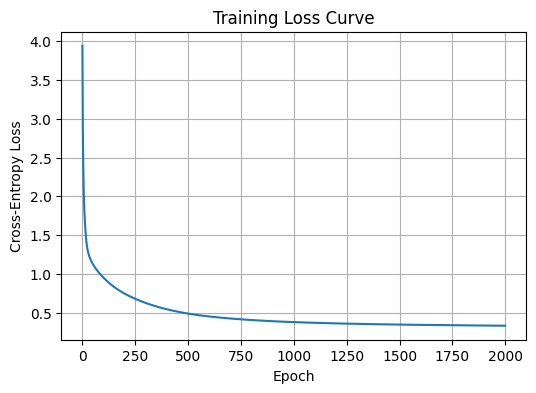

In [ ]:
# Training
NN = NeuralNetwork()
errors = []
epochs = 2000

for i in range(epochs):
    loss = NN.train_one_epoch(X_train, Y_train)
    errors.append(loss)

    if i % 200 == 0:
        print(f"Epoch: {i}  Loss: {loss:.4f}")

# Plot training loss curve
plt.figure(figsize=(6, 4))
plt.plot(errors)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()


Confusion Matrix

Test Accuracy: 0.8453333333333334

Class 0:
 Precision: 0.9062499999055991
 Recall   : 0.639705882305904
 F1-Score : 0.7499999950839775

Class 1:
 Precision: 0.7555555553876543
 Recall   : 0.8947368418698061
 F1-Score : 0.8192771032718827

Class 2:
 Precision: 0.7714285713183674
 Recall   : 0.9642857141135204
 F1-Score : 0.8571428520685312

Class 3:
 Precision: 0.7647058822404845
 Recall   : 0.9454545452826446
 F1-Score : 0.8455284502029218

Class 4:
 Precision: 0.9374999999023438
 Recall   : 0.999999999888889
 F1-Score : 0.9677419303850158

Macro-average:
 Precision: 0.8270880017508897
 Recall   : 0.8888365966921528
 F1-Score : 0.8479380662024658


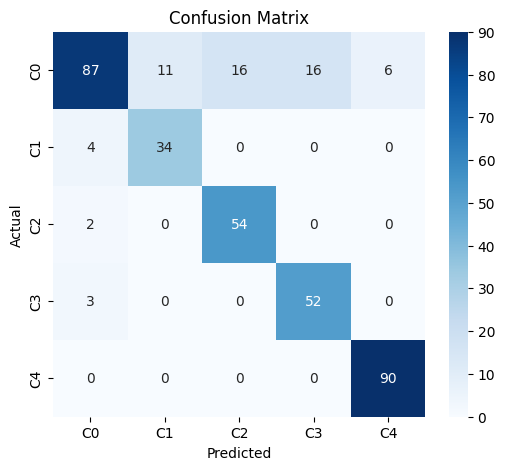

In [ ]:
# Testing and Evaluation
pred_test = NN.feedForward(X_test)        # probabilities
y_pred = np.argmax(pred_test, axis=1)     # predicted class indices
y_true = np.argmax(Y_test, axis=1)        # true class indices

# Accuracy
accuracy = np.mean(y_pred == y_true)
print("Test Accuracy:", accuracy)

# Precision, Recall, F1-score (per class + macro)
num_classes = 5
precision = []
recall = []
f1 = []

for c in range(num_classes):
    TP = np.sum((y_pred == c) & (y_true == c))
    FP = np.sum((y_pred == c) & (y_true != c))
    FN = np.sum((y_pred != c) & (y_true == c))

    prec = TP / (TP + FP + 1e-8)
    rec  = TP / (TP + FN + 1e-8)
    f1_c = 2 * prec * rec / (prec + rec + 1e-8)

    precision.append(prec)
    recall.append(rec)
    f1.append(f1_c)

    print(f"\nClass {c}:")
    print(" Precision:", prec)
    print(" Recall   :", rec)
    print(" F1-Score :", f1_c)

print("\nMacro-average:")
print(" Precision:", np.mean(precision))
print(" Recall   :", np.mean(recall))
print(" F1-Score :", np.mean(f1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=[f"C{i}" for i in range(num_classes)],
            yticklabels=[f"C{i}" for i in range(num_classes)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


5. Results and Analysis

The training loss decreases steadily over the epochs, indicating that the three-hidden-layer neural network successfully learns meaningful decision boundaries in the synthetic 2D feature space.  
On the test set, the model achieves a reasonably high accuracy, and the per-class precision, recall and F1-score values show that all five classes are learned to a satisfactory level.

The confusion matrix confirms that most predictions lie on the diagonal, meaning that the true and predicted labels often match.  
Misclassifications tend to occur near the boundaries between the regions defined for each class, where samples are more ambiguous by construction.

 6. Conclusion

A three-hidden-layer neural network for five-class classification has been implemented by extending the original binary-class code.  
The modifications include:

1.Generating a synthetic dataset with five distinct classes,
2.Redesigning the network architecture to have three hidden layers and five output neurons,

3.Sing ReLU activations in the hidden layers and softmax in the output layer, and

4.Adopting categorical cross-entropy as the loss function with backpropagation adapted to the multi-class setting.

The final model performs well on the synthetic dataset and demonstrates that a relatively simple fully connected network can handle multi-class classification tasks effectively.  
Further improvements could include trying different network sizes, alternative optimizers (such as Adam), and regularization techniques (such as L2 or dropout) to study their effect on performance and generalization.
